import block

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier #not using K nearest
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import spacy
import contractions
import re
import numpy
import heapq
import warnings
import gensim
from gensim.models import Word2Vec
lemmatizer = WordNetLemmatizer()
tfidf = TfidfVectorizer(min_df=5, max_features=200)
CountVectorizer = CountVectorizer()
warnings.filterwarnings(action = 'ignore')
stopwords = set(stopwords.words('english'))
stopwords.remove('no')
stopwords.remove('not')
stopwords.remove('nor')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avamc_srsebwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avamc_srsebwe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avamc_srsebwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Exploratory Data Analysis

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train = train.truncate(before=750000, after=850000)
train = train.sample(frac=.1, random_state = 8)
#check for na cells
train.isna().sum()
#no na cells

Index        0
Sentiment    0
Text         0
dtype: int64

[Text(0.5, 1.0, 'Sentiment Counts')]

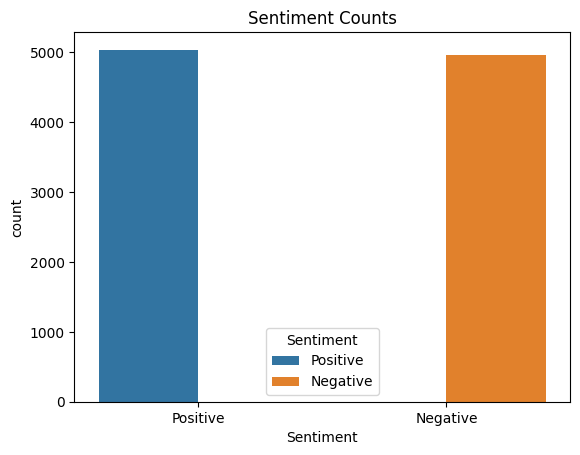

In [29]:
#look at distribution
sns.countplot(data=train.assign(Sentiment=train.Sentiment.map({0: "Negative", 1: "Positive"})), x='Sentiment', hue='Sentiment').set(title='Sentiment Counts')

As the graph above indicates, there are many more examples of negative sentiment in the data.

# Step 2: Text Preprocessing

Methods Used:
1. change to lower
2. expand contractions
3. remove special chars, punctuation, and digital numbers
4. remove stop words except not, no, and nor (done in lemm+token section)

In [3]:
def cleanTheData(data):
    #data is one string from df
    
    #expand contractions and go to lowercase
    data = contractions.fix(data.lower()) 
    data = re.sub('[^a-z]', ' ', data)
    return data

#quick sample test run
'''
df2= test = pd.read_csv('test.csv')
df2["A"] = df2['Text'].apply(cleanTheData)
df2.head()
'''
        
train['Text'] = train['Text'].apply(cleanTheData)
test['Text'] = test['Text'].apply(cleanTheData)

train.head()

,Index,Sentiment,Text
847733,847733,1,good morning everyone happy start of the new ...
791554,791554,0,take a break from work it is hot outside and ...
773068,773068,0,mikeyxscene i was just jokeing around
796610,796610,0,damn i failed the fuck out that test got ...
802491,802491,1,hollywood trey


Lemmatizing & Tokenization

In [4]:
train_cleaned = []
train_lemmatized = []
word2count = {}
for sent in train['Text']:
    temp = []
    temp1 = []
    for w in sent.split():
        if w not in stopwords:
            word = lemmatizer.lemmatize(w)
            temp.append(word_tokenize(word))
            temp1.append(word)
            if w not in word2count.keys():
                word2count[w] = 1
            else:
                word2count[w] += 1
    train_cleaned.append(temp)
    train_lemmatized.append(temp1)
unique_words = list(word2count.keys())

In [5]:
test_cleaned = []
test_lemmatized = []
word2count_test = {}
for sent in test['Text']:
    temp = []
    temp1 = []
    for w in sent.split():
        if w not in stopwords:
            word = lemmatizer.lemmatize(w)
            temp.append(word_tokenize(word))
            temp1.append(word)
            if w not in word2count_test.keys():
                word2count_test[w] = 1
            else:
                word2count_test[w] += 1
    test_cleaned.append(temp)
    test_lemmatized.append(temp1)
unique_words_test = list(word2count_test.keys())

In [34]:
for i in range(5):
  print(train_cleaned[i])

[['good'], ['morning'], ['everyone'], ['happy'], ['start'], ['new'], ['week']]
[['take'], ['break'], ['work'], ['hot'], ['outside'], ['work']]
[['mikeyxscene'], ['jokeing'], ['around']]
[['damn'], ['failed'], ['fuck'], ['test'], ['got'], ['stop'], ['party']]
[['hollywood'], ['trey']]


Only keep unique words with counts above 40

In [6]:
print(dict(sorted(word2count.items(), reverse=True, key=lambda item: item[1])))

{'not': 1746, 'good': 591, 'going': 538, 'day': 513, 'like': 502, 'get': 486, 'http': 452, 'quot': 450, 'no': 448, 'today': 447, 'go': 444, 'work': 439, 'got': 426, 'cannot': 424, 'love': 418, 'time': 370, 'com': 364, 'back': 354, 'know': 339, 'one': 336, 'really': 326, 'lol': 323, 'want': 321, 'amp': 313, 'would': 290, 'see': 277, 'well': 276, 'still': 272, 'twitter': 265, 'think': 263, 'new': 258, 'night': 253, 'thanks': 247, 'sad': 240, 'miss': 238, 'great': 233, 'hope': 227, 'morning': 226, 'oh': 226, 'home': 226, 'much': 223, 'need': 219, 'though': 203, 'could': 195, 'sorry': 187, 'right': 184, 'last': 183, 'bad': 179, 'haha': 179, 'feel': 176, 'sleep': 176, 'wish': 173, 'way': 172, 'tomorrow': 171, 'getting': 166, 'nice': 166, 'fun': 166, 'yeah': 163, 'people': 161, 'come': 157, 'better': 157, 'x': 155, 'wait': 154, 'even': 152, 'watching': 149, 'make': 149, 'us': 142, 'tonight': 140, 'soon': 136, 'days': 135, 'happy': 132, 'twitpic': 131, 'week': 130, 'take': 130, 'next': 123, '

In [7]:
print(len(unique_words))
unique_words_shortened = heapq.nlargest(int(100), word2count, key=word2count.get)
print(len(unique_words_shortened))
print(unique_words_shortened)

17714
100
['not', 'good', 'going', 'day', 'like', 'get', 'http', 'quot', 'no', 'today', 'go', 'work', 'got', 'cannot', 'love', 'time', 'com', 'back', 'know', 'one', 'really', 'lol', 'want', 'amp', 'would', 'see', 'well', 'still', 'twitter', 'think', 'new', 'night', 'thanks', 'sad', 'miss', 'great', 'hope', 'morning', 'oh', 'home', 'much', 'need', 'though', 'could', 'sorry', 'right', 'last', 'bad', 'haha', 'feel', 'sleep', 'wish', 'way', 'tomorrow', 'getting', 'nice', 'fun', 'yeah', 'people', 'come', 'better', 'x', 'wait', 'even', 'watching', 'make', 'us', 'tonight', 'soon', 'days', 'happy', 'twitpic', 'week', 'take', 'next', 'hey', 'thank', 'hate', 'bed', 'bit', 'please', 'let', 'little', 'life', 'working', 'yes', 'cool', 'school', 'tired', 'say', 'thing', 'already', 'n', 'never', 'yet', 'watch', 'long', 'something', 'first', 'friends']


In [8]:
print(len(unique_words_test))
unique_words_test_shortened = heapq.nlargest(int(100), word2count_test, key=word2count_test.get)
print(len(unique_words_test_shortened))
print(unique_words_test_shortened)

1588
100
['http', 'not', 'time', 'warner', 'good', 'love', 'amp', 'bit', 'night', 'new', 'ly', 'com', 'hate', 'got', 'great', 'kindle', 'lebron', 'go', 'nike', 'gm', 'today', 'museum', 'obama', 'google', 'get', 'going', 'like', 'back', 'best', 'twitter', 'awesome', 'rt', 'really', 'day', 'much', 'see', 'dentist', 'want', 'no', 'still', 'would', 'cannot', 'malcolm', 'gladwell', 'g', 'cable', 'one', 'last', 'lol', 'api', 'exam', 'damn', 'latex', 'never', 'aig', 'iphone', 'phone', 'www', 'using', 'internet', 'happy', 'jquery', 'shit', 'lakers', 'us', 'place', 'stanford', 'lt', 'could', 'work', 'ever', 'fail', 'safeway', 'bobby', 'reading', 'guy', 'come', 'way', 'p', 'star', 'trek', 'tinyurl', 'book', 'man', 'north', 'korea', 'insects', 'wish', 'mcdonalds', 'well', 'sucks', 'speech', 'thing', 'goodby', 'silverstein', 'free', 'watching', 'pretty', 'yes', 'f']


# Step 3: Linguistic Feature Extraction

## Bag-of-Words

In [9]:
bow = []
for data in train_cleaned:
    bag_vector = numpy.zeros(len(unique_words_shortened))
    for w in data:
        for i, word in enumerate(unique_words_shortened):
            if word == w:
                bag_vector[i] += 1
    bow.append(bag_vector)

In [10]:
bdf = pd.DataFrame(bow)
bdf.columns = unique_words_shortened
#bdf.to_csv("bow.csv")

In [11]:
bow_test = []
for data in test_cleaned:
    bag_vector = numpy.zeros(len(unique_words_test_shortened))
    for w in data:
        for i, word in enumerate(unique_words_test_shortened):
            if word == w:
                bag_vector[i] += 1
    bow_test.append(bag_vector)

In [12]:
bdf_test = pd.DataFrame(bow_test)
bdf_test.columns = unique_words_test_shortened
#bdf.to_csv("bow.csv")

## TF*IDF

In [12]:
#trunc_train = train

In [25]:
clean_df = pd.DataFrame(train_lemmatized)
process_df = pd.DataFrame()
process_df =  clean_df.apply(lambda x: ' '.join(x.dropna()), axis=1)
#process_df =  clean_df[290000:310000].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [26]:
clean_test = pd.DataFrame(test_lemmatized)
process_test = pd.DataFrame()
process_test =  clean_test.apply(lambda x: ' '.join(x.dropna()), axis=1)

In [27]:
tfidf_vector = tfidf.fit_transform(process_df)
tfidf_array = tfidf_vector.toarray()


tfidf_vector_test = tfidf.transform(process_test)
tfidf_array_test = tfidf_vector_test.toarray()

In [28]:
tfdf = pd.DataFrame(tfidf_array)
tfdf.columns = tfidf.get_feature_names_out()
#tfdf.to_csv("tfdf.csv")

tfdf_test = pd.DataFrame(tfidf_array_test)
tfdf_test.columns = tfidf.get_feature_names_out()

## Word2Vec

In [55]:
clean_df = pd.DataFrame(train_lemmatized)
new_df = pd.DataFrame()
new_df =  clean_df.apply(lambda x: ' '.join(x.dropna()), axis=1)

#Label
y_w2v_train = train['Sentiment'].to_numpy()
#Training data.. all attributes
x_w2v_train = new_df.to_numpy()

clean_test = pd.DataFrame(test_lemmatized)
new_test = pd.DataFrame()
new_test =  clean_test.apply(lambda x: ' '.join(x.dropna()), axis=1)

#Label
y_w2v_test = test['Sentiment'].to_numpy()
#Training data.. all attributes
x_w2v_test = new_test.to_numpy()

In [56]:
trained_w2v = [sentence.split() for sentence in x_w2v_train]

In [57]:
#use train_lemmatized

#create CBOW model
w2v = gensim.models.Word2Vec(trained_w2v, min_count = 40, vector_size = 100, window = 5, sg=0, workers=4)

Vectorize the text data

In [58]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v.wv[word] for word in words if word in w2v.wv]
    if len(words_vecs) == 0:
        return numpy.zeros(100)
    words_vecs = numpy.array(words_vecs)
    return words_vecs.mean(axis=0)
    
x_train_w2v_vect = numpy.array([vectorize(sentence) for sentence in x_w2v_train])
X_test_w2v_vect = numpy.array([vectorize(sentence) for sentence in x_w2v_test])

# Step 4: Sentiment Classification Models

ML Algorithms
- Logistic Regression
- SVC
- Naive Bayes
- Random Forest

Feature Extractions
- Bag-of-Words
- TF*IDF
- Word2Vec

In [33]:
lc = LogisticRegression()
svc = SVC(probability=True)
nbc = GaussianNB() #naive bayes
rfc = RandomForestClassifier()

## Bag-of-Words : LR, SVC, Naive Bayes, Random Forest

Data Scaling and Splitting

In [82]:
#Label
y_train = train['Sentiment'].to_numpy()
#Training data.. all attributes
x_train = bdf.to_numpy()

#Label
y_test = test['Sentiment'].to_numpy()
#Training data.. all attributes
x_test = bdf_test.to_numpy()

#if values are really high compared to other values. this will cause weights to be based on values.
#may cause unstable issues . but scaled will fix that
scale = StandardScaler() #from sklearn
x_train = scale.fit_transform(x_train) #give scaler function input of dataset in order to scale data
x_test = scale.transform(x_test)


In [83]:
lc.fit(x_train, y_train) #this trains the model
#lc is initialized logistic regression model 
svc.fit(x_train, y_train)
nbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

Testing the 4 models with Bag-of-Words Testing Dataset

In [84]:
#testing model with testing dataset

y_lc_predicted = lc.predict(x_test)#predicted results of test dataset
y_lc_pred_proba = lc.predict_proba(x_test)

y_svc_predicted = svc.predict(x_test)
y_svc_pred_proba = svc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

y_rfc_predicted = rfc.predict(x_test)
y_rfc_pred_proba = rfc.predict_proba(x_test)

In [85]:
y_nbc_pred_proba[numpy.isnan(y_nbc_pred_proba)] = 0

Print Results of 3 classifiers using Bag-of-Words 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.51      1.00      0.67       182

    accuracy                           0.51       359
   macro avg       0.25      0.50      0.34       359
weighted avg       0.26      0.51      0.34       359

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.51      1.00      0.67       182

    accuracy                           0.51       359
   macro avg       0.25      0.50      0.34       359
weighted avg       0.26      0.51      0.34       359

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       177
           1       0.00      0.00      0.00       182

    accuracy                           0.49       359
   macro avg       0.25      0.50      0.33       359
weighted avg       0.24      0.49      0.33       359

              preci

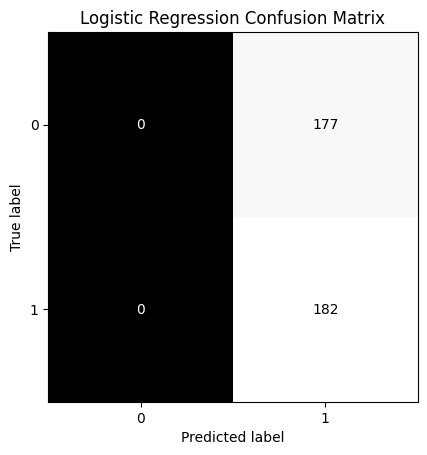

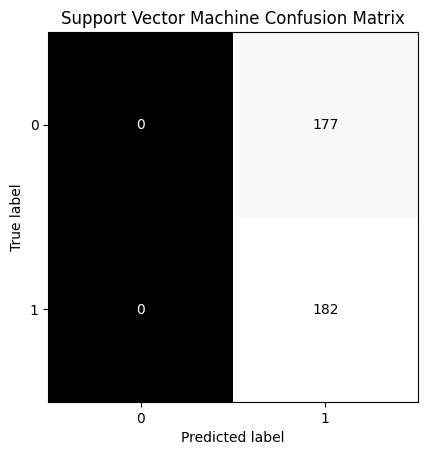

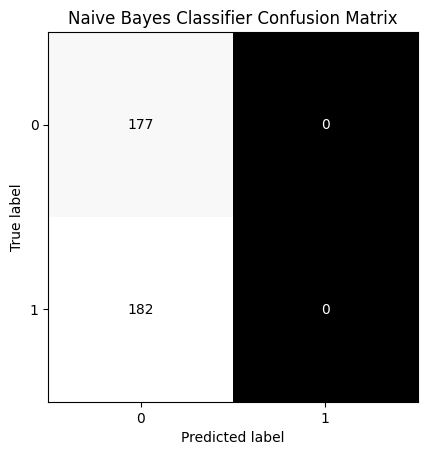

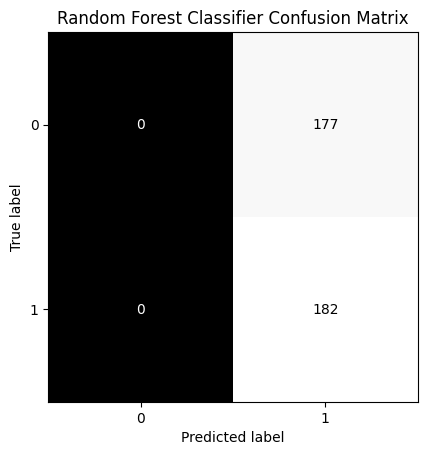

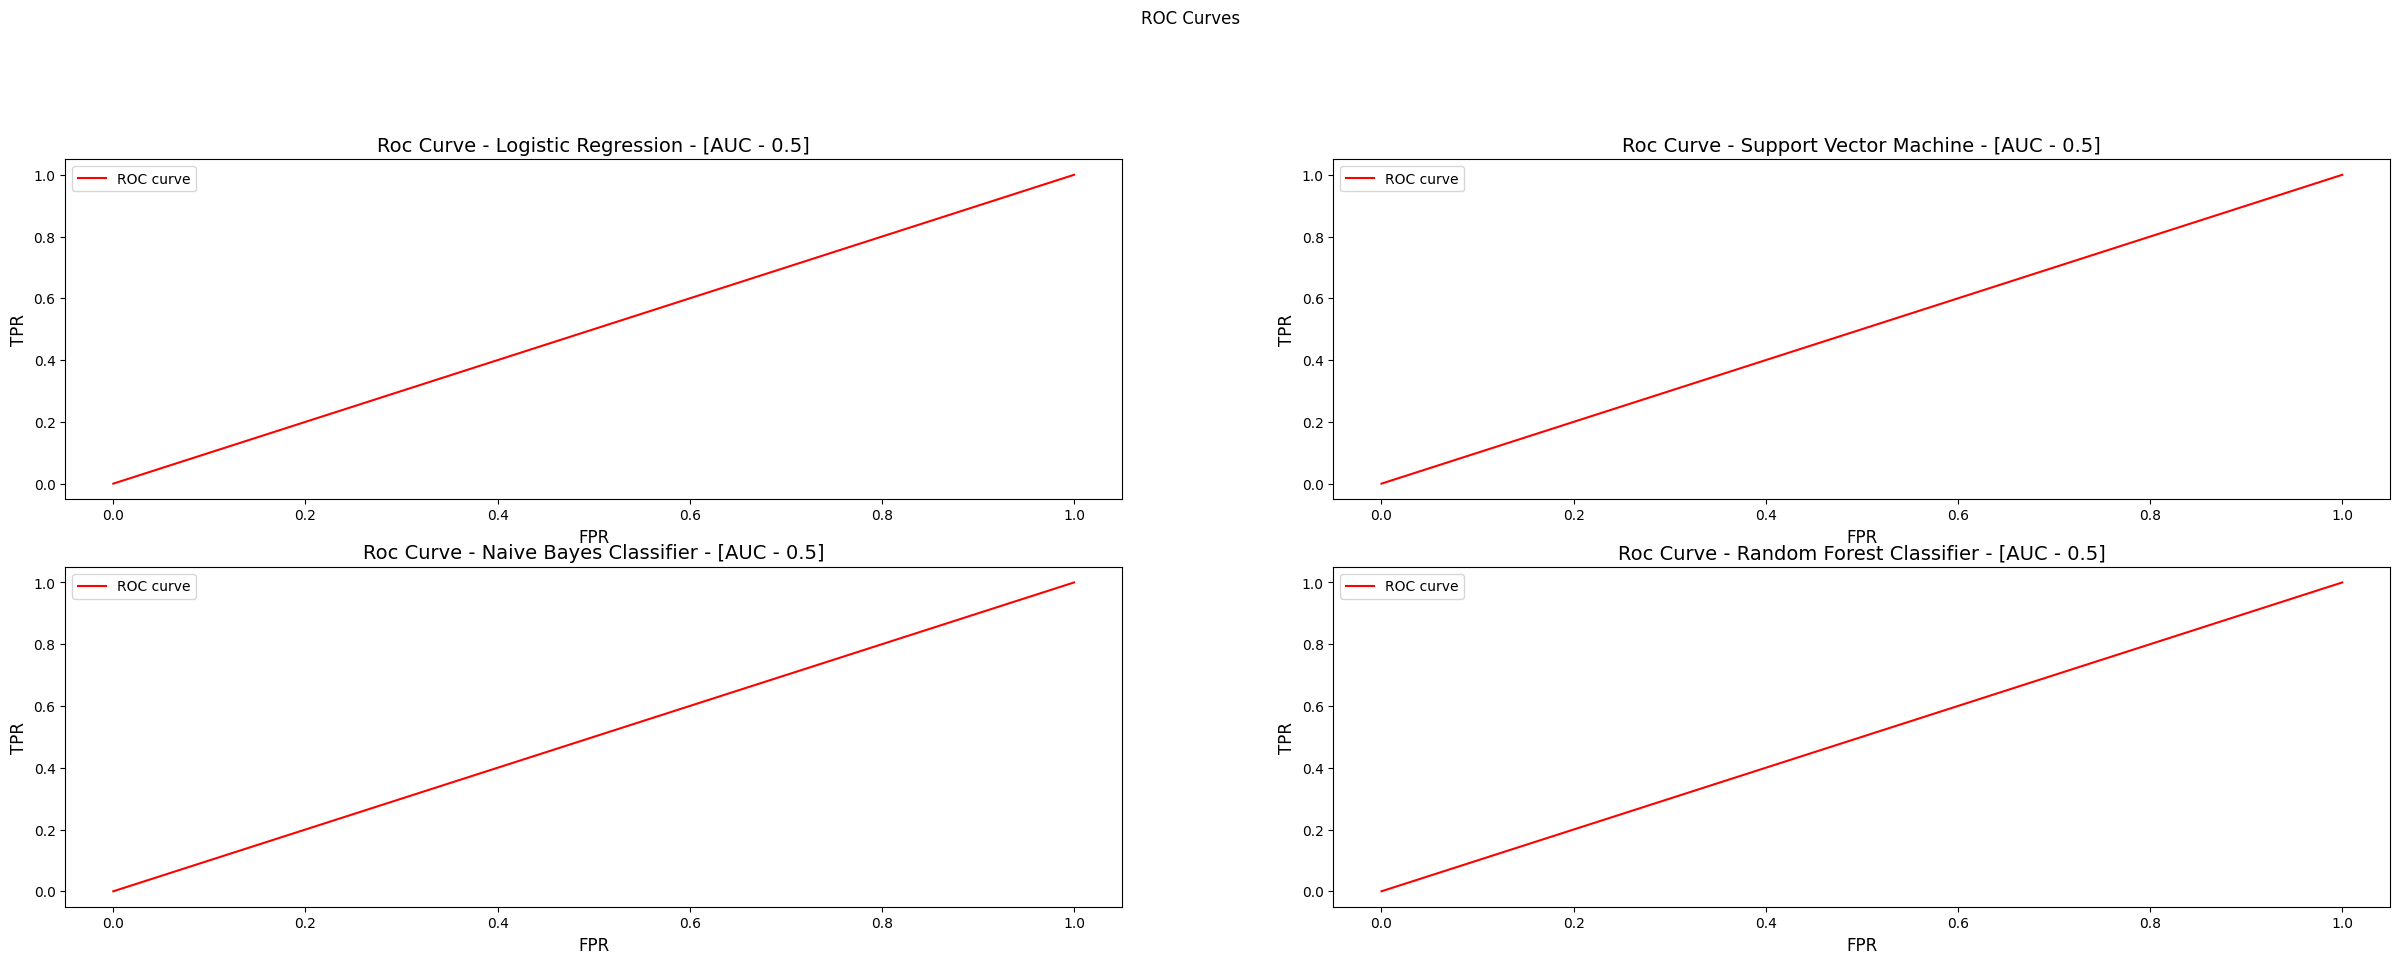

In [86]:
print(classification_report(y_test, y_lc_predicted))
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    #pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### TF*IDF : LR, SVC, Naive Bayes, Random Forest

In [48]:
#Label
y_train = train['Sentiment'].to_numpy()
#Training data.. all attributes
x_train = tfdf.to_numpy()

y_test = test['Sentiment'].to_numpy()
#Training data.. all attributes
x_test = tfdf_test.to_numpy()

#if values are really high compared to other values. this will cause weights to be based on values.
#may cause unstable issues . but scaled will fix that

scale = StandardScaler() #from sklearn
x_train = scale.fit_transform(x_train) #give scaler function input of dataset in order to scale data
x_test = scale.transform(x_test) 

Testing 3 Models using TF*IDF

In [49]:
#train ML model with training dataset 
#these are all different models to train dataset

lc.fit(x_train, y_train) #this trains the model
#lc is initialized logistic regression model 
svc.fit(x_train, y_train)
nbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [50]:
#testing model with testing dataset

y_lc_predicted = lc.predict(x_test)#predicted results of test dataset
y_lc_pred_proba = lc.predict_proba(x_test)

y_svc_predicted = svc.predict(x_test)
y_svc_pred_proba = svc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

y_rfc_predicted = rfc.predict(x_test)
y_rfc_pred_proba = rfc.predict_proba(x_test)

Print Results of 3 Classifiers using TF*IDF

              precision    recall  f1-score   support

           0       0.75      0.58      0.66       177
           1       0.67      0.81      0.73       182

    accuracy                           0.70       359
   macro avg       0.71      0.70      0.69       359
weighted avg       0.71      0.70      0.69       359

              precision    recall  f1-score   support

           0       0.72      0.55      0.62       177
           1       0.64      0.79      0.71       182

    accuracy                           0.67       359
   macro avg       0.68      0.67      0.67       359
weighted avg       0.68      0.67      0.67       359

              precision    recall  f1-score   support

           0       0.71      0.56      0.63       177
           1       0.65      0.78      0.71       182

    accuracy                           0.67       359
   macro avg       0.68      0.67      0.67       359
weighted avg       0.68      0.67      0.67       359

              preci

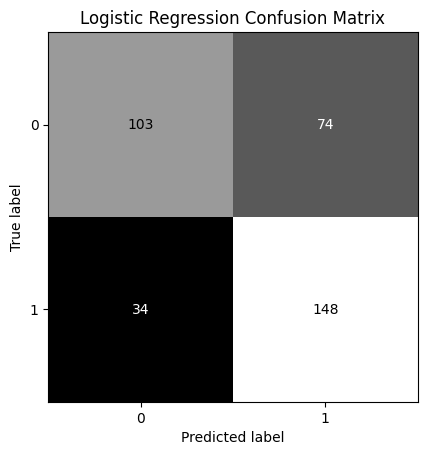

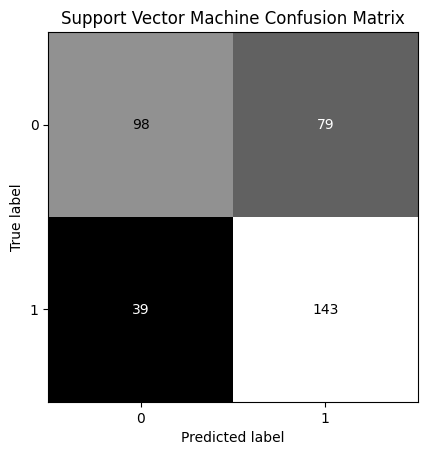

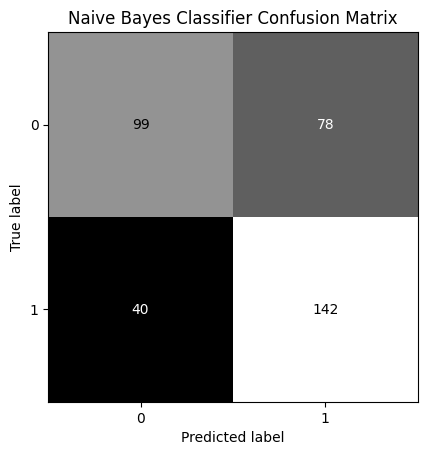

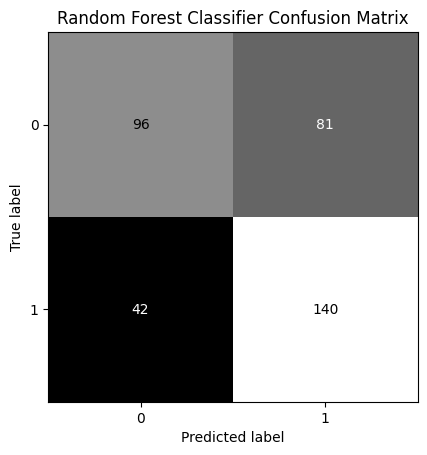

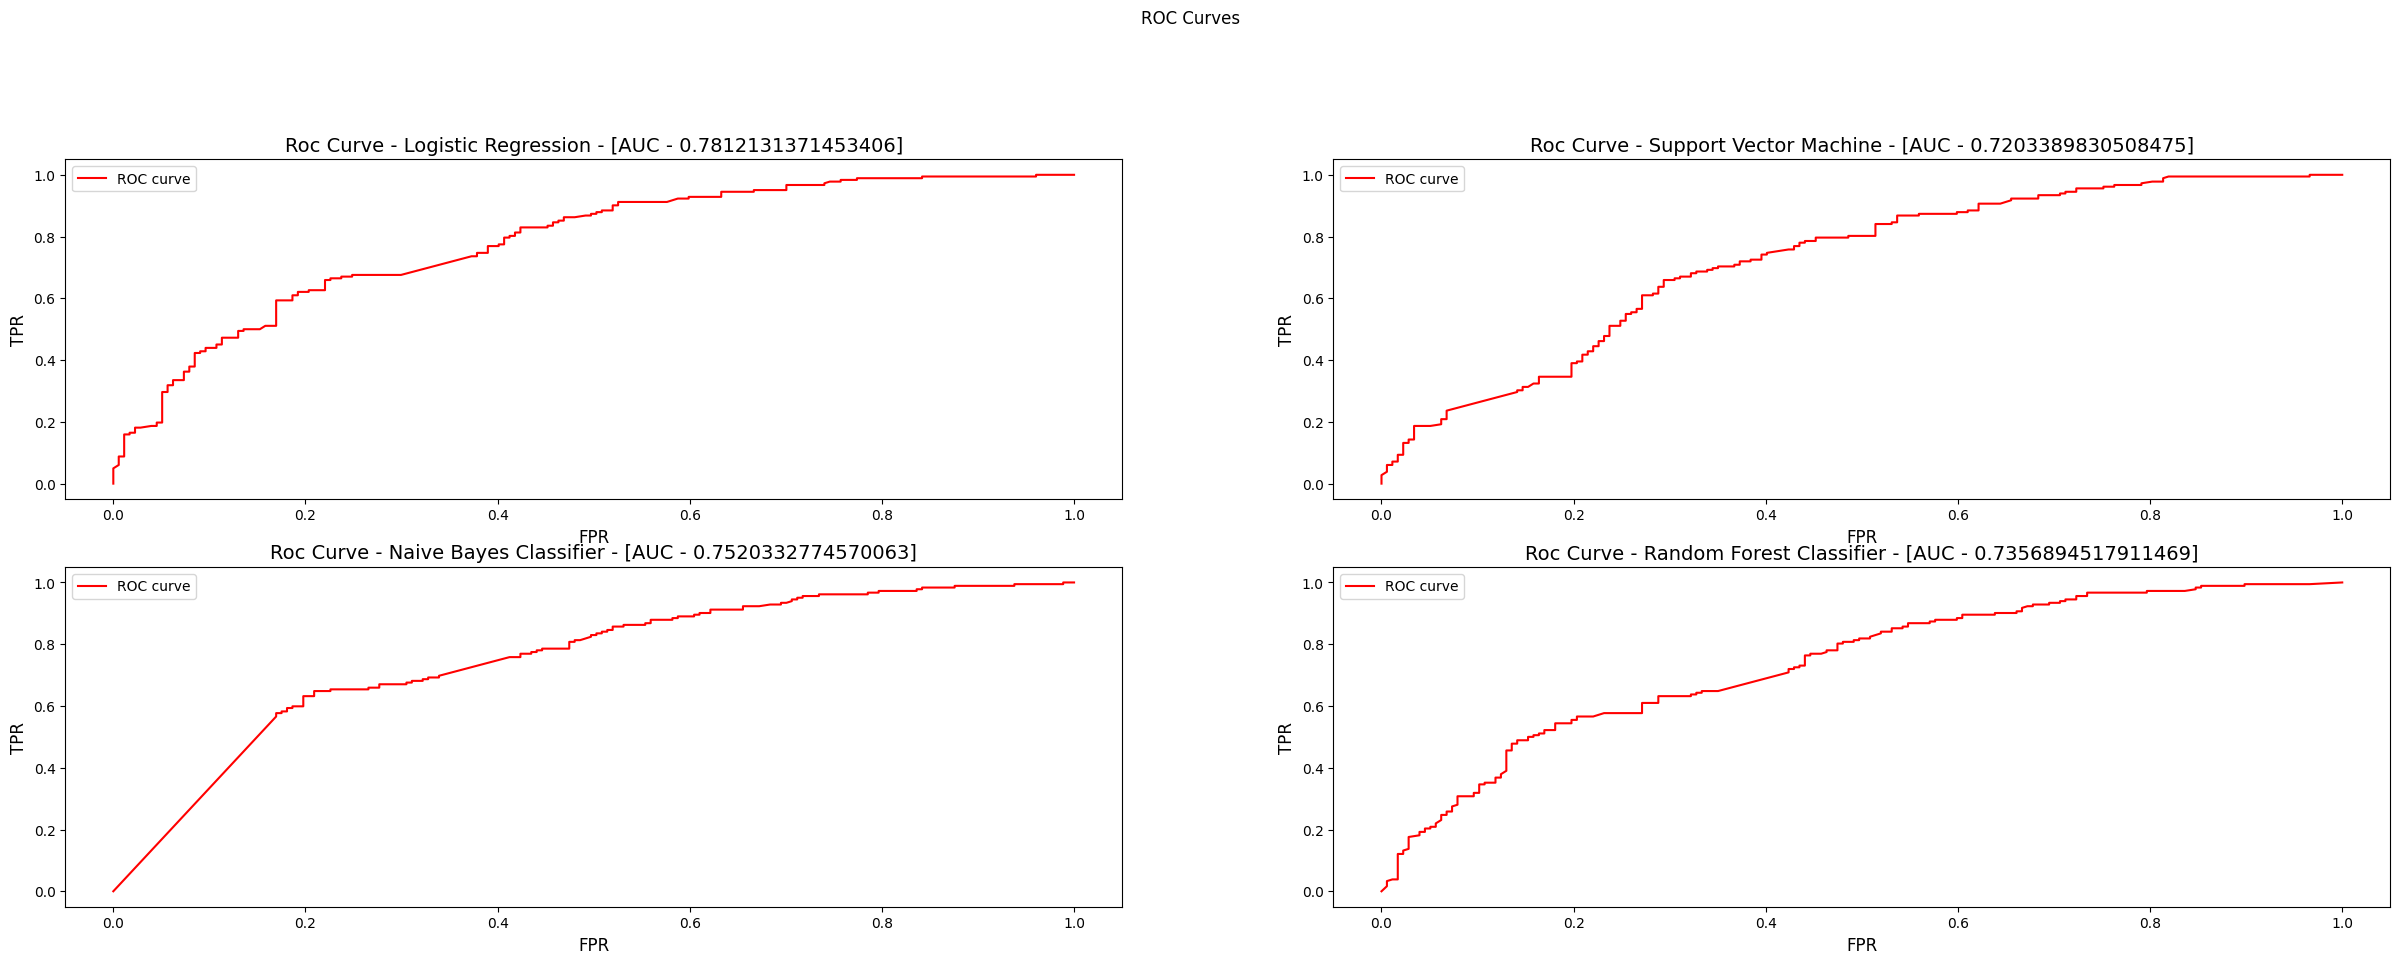

In [51]:
print(classification_report(y_test, y_lc_predicted))
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### Word2Vec : LR, SVC, Naive Bayes, Random Forest

In [59]:
# x_train_w2v_vect
lc.fit(x_train_w2v_vect, y_w2v_train)
svc.fit(x_train_w2v_vect, y_w2v_train)
nbc.fit(x_train_w2v_vect, y_w2v_train)
rfc.fit(x_train_w2v_vect, y_w2v_train)

RandomForestClassifier()

Testing 3 Models with Word2Vec

In [60]:
#testing model with testing dataset

y_lc_predicted = lc.predict(X_test_w2v_vect)#predicted results of test dataset
y_lc_pred_proba = lc.predict_proba(X_test_w2v_vect)

y_svc_predicted = svc.predict(X_test_w2v_vect)
y_svc_pred_proba = svc.predict_proba(X_test_w2v_vect)

y_nbc_predicted = nbc.predict(X_test_w2v_vect)
y_nbc_pred_proba = nbc.predict_proba(X_test_w2v_vect)

y_rfc_predicted = rfc.predict(X_test_w2v_vect)
y_rfc_pred_proba = rfc.predict_proba(X_test_w2v_vect)

Print Results

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       177
           1       0.65      0.61      0.63       182

    accuracy                           0.64       359
   macro avg       0.64      0.64      0.64       359
weighted avg       0.64      0.64      0.64       359

              precision    recall  f1-score   support

           0       0.53      0.84      0.65       177
           1       0.65      0.28      0.39       182

    accuracy                           0.56       359
   macro avg       0.59      0.56      0.52       359
weighted avg       0.59      0.56      0.52       359

              precision    recall  f1-score   support

           0       0.52      0.86      0.65       177
           1       0.62      0.22      0.33       182

    accuracy                           0.54       359
   macro avg       0.57      0.54      0.49       359
weighted avg       0.57      0.54      0.48       359

              preci

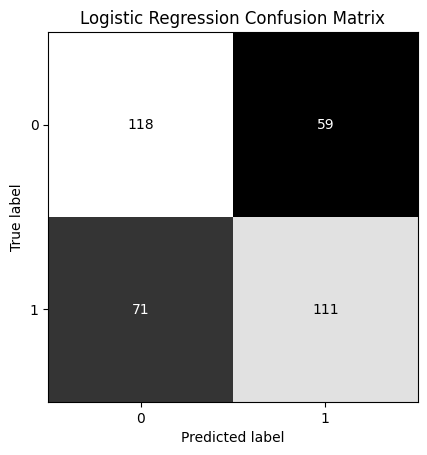

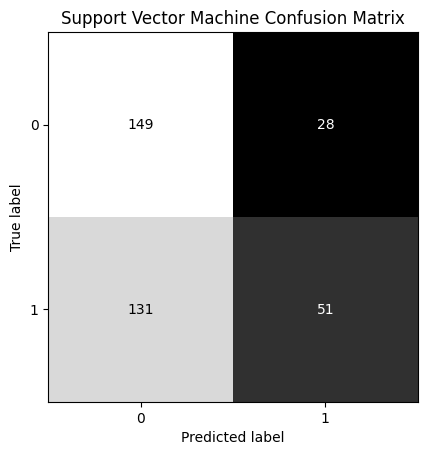

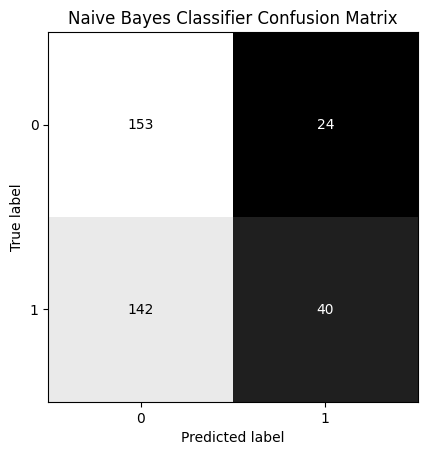

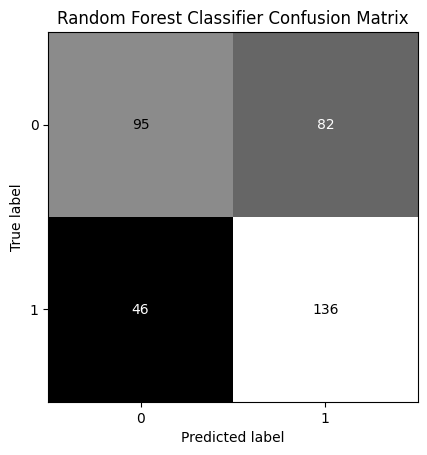

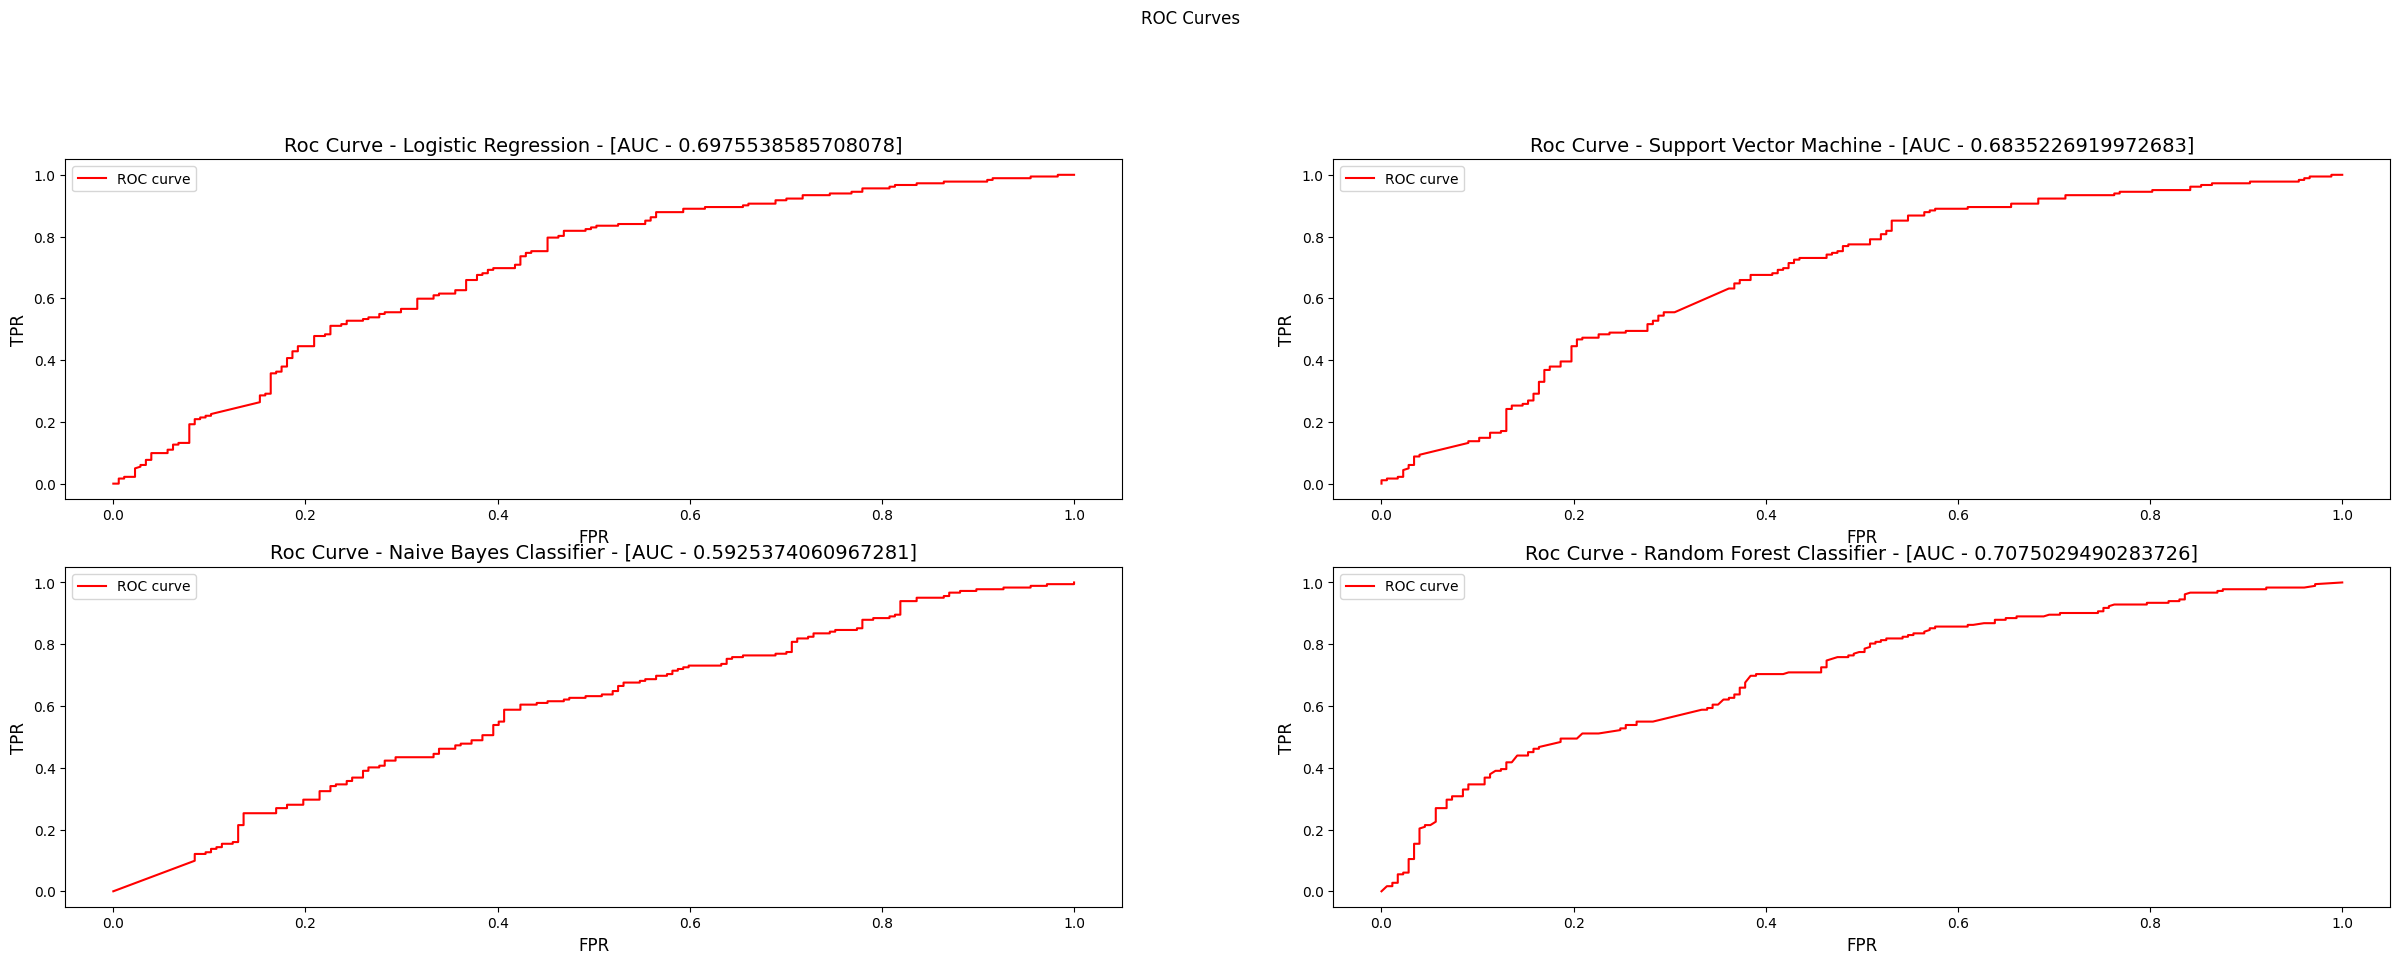

In [61]:
print(classification_report(y_w2v_test, y_lc_predicted))
print(classification_report(y_w2v_test, y_svc_predicted))
print(classification_report(y_w2v_test, y_nbc_predicted))
print(classification_report(y_w2v_test, y_rfc_predicted))

models = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()